# Overview of the evaluation module

The evaluation module provides a set of functionalities that can help you assess the performance of your bias correction method. Bias correction is prone to mis-use and requires careful evaluation, as demonstrated and argued in Maraun et al. 2017. In particular, the bias correction methods implemented in this package operate on a marginal level, that is they correct distribution of individual variables at individual locations. There is therefore only a subset of climate model biases that these debiasers will be able to correct. Biases in the temporal or spatial structure of climate models, or the feedbacks to large-scale weather patterns might not be well corrected. 

It is therefore important to evaluate not only marginal but also temporal, spatial and spatiotemporal properties of the bias corrected model to gain insight into which biases have been corrected, and which remain after debiasing that hint towards larger-scale issues with the climate model used.

**There are three components to the evaluation module:**
- **Testing assumptions of different debiasers**: Different debiasers rely on different assumptions - some are parametrics, others non-parametric, some bias correct each day of the year separately, others are applied to all days of the year in the same way. This components is meant to check some of these assumptions and help the user rule out the use of some debiasers that are not fit for purpose in this specific application.
- **Evaluating the bias corrected model on a validation period**: In order to assess the performance of a bias correction method, the bias corrected model data should be compared to observational / reanalysis data. This component provides insight into the correction of marginal biases, as well as temporal, spatial and spatiotemporal metrics.
- **Investigating whether the climate change trend is preserved**: Bias correction methods can significantly modify the trend projected in the climate model simulation (Switanek 2017). If the user does not consider the simulated trend to be credible, then modifying it can be a good thing to do. However, any trend modification should always be a concious and informed choice, and it the belief that a bias correction method will improve the trend should be justified. Otherwise, the trend modification through the application of a bias correction method should be considered an artifact. Therefore, this section assesses whether a certain method preserves the cliamte model trend or not. Some methods implemented in this package are explicitly trend preserving, for more details see the methodologies and descriptions of the individual debiasers.

**This notebook demonstrates the evaluation of three debiasers, ISIMIP (Lange 2021), CDFt (Vrac 2017) and Quantile Delta Mapping (Cannon et al 2015) to the variables tas (daily mean 2m surface temperature, K) and pr (total daily precipitation flux, kg/m2/s). ISIMIP is additionally applied to tasmin (daily minimum 2m surface temperature, K) and tasmax (daily maximum 2m surface temperature, K)**

## Set-up and data pre-processing

This step requires you to have downloaded and preprocessed observational or reanalysis data (such as ERA5) as well as a historical, as well as a future simulation of a climate model. Necessary pre-processing steps include regridding the datasets to the same area and grid in space and time and conducted checks for corrupted or missing data. If you don't have testing data yet, you can either work with the testing data stored in FOLDER, or use the PREPROCESS_NOTEBOOK to download new testing data.

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [6]:
import numpy as np
import iris
import math

from scipy.stats import norm, laplace, gamma

from PACKAGE_NAME.variables import *
from PACKAGE_NAME.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from PACKAGE_NAME.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from PACKAGE_NAME.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from PACKAGE_NAME.evaluate import assumptions, correlation, marginal, spatial, trend
from PACKAGE_NAME.evaluate.metrics import *

**OPEN QUESTION: put these functions somewhere**

In [7]:
from cf_units import num2date

def get_dates(x):
    
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable, split_ratio):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    if obs_all.shape != cm.shape:
        raise ValueError('Observation and climate model data do not have same dimensions.')
    
    boundary_step = math.floor(obs_all.shape[2]*split_ratio)
    
    obs = obs_all[:, :, 0:boundary_step]
    obs_validate = obs_all[:, :, boundary_step+1:]
    cm_hist = cm[:, :, 0:boundary_step]
    cm_validate = cm[:, :, boundary_step+1:]
    
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_validate),
    }
    
    dates_future = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_validate = np.transpose(np.array(cm_validate.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, dates, dates_future

Initialize testing data and dates for tas and pr

In [8]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_dates_validate, tas_dates_future = preprocess_isimip_evaluation_testing_data('tas', 0.7)
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_dates_validate, pr_dates_future = preprocess_isimip_evaluation_testing_data('pr', 0.7)

**Calculating tasmin and tasmax**: currently only ISIMIP covers tasmin and tasmax. It also does not bias correct these two variables directly, but rather bias corrects the variables tasrange and tasskew, where 

$$ tasrange = tasmax - tasmin $$

and 

$$ tasskew = \frac{tas − tasmin}{tasrange} $$

The utils function 'get_tasmin_tasmax' calculates tasmin and tasmax from tasrange and tasskew.

In [10]:
tasrange_obs, tasrange_obs_validate, tasrange_cm_hist, tasrange_cm_validate, tasrange_cm_future, tasrange_dates_validate, tasrange_dates_future = preprocess_isimip_evaluation_testing_data('tasrange', 0.7)
tasskew_obs, tasskew_obs_validate, tasskew_cm_hist, tasskew_cm_validate, tasskew_cm_future, tasskew_dates_validate, tasskew_dates_future = preprocess_isimip_evaluation_testing_data('tasskew', 0.7)

tasmin_obs, tasmax_obs = utils.get_tasmin_tasmax(tas = tas_obs, tasrange = tasrange_obs, tasskew = tasskew_obs)
tasmin_obs_validate, tasmax_obs_validate = utils.get_tasmin_tasmax(tas = tas_obs_validate, tasrange = tasrange_obs_validate, tasskew = tasskew_obs_validate)
tasmin_cm_hist, tasmax_cm_hist = utils.get_tasmin_tasmax(tas = tas_cm_hist, tasrange = tasrange_cm_hist, tasskew = tasskew_cm_hist)
tasmin_cm_validate, tasmax_cm_validate = utils.get_tasmin_tasmax(tas = tas_cm_validate, tasrange = tasrange_cm_validate, tasskew = tasskew_cm_validate)
tasmin_cm_future, tasmax_cm_future = utils.get_tasmin_tasmax(tas = tas_cm_future, tasrange = tasrange_cm_future, tasskew = tasskew_cm_future)

## Part 1: Testing assumptions

Different bias correction methods rely on different assumptions, as described above. A detailed overview of assumptions associated with a specific bias correction method can be found in the documentation of each debiaser. For the sake of demonstration, we investigate the goodness of fit in this notebook:

For all parametric methods, distributions are fitted to the data. Default distributions for each variable are specified in the individual debiasers. We assess the following two components:
- Is the fit of the default distribution 'good enough' or should a different distribution be used?
- Is there any seasonality in the data that should be accounted for, for example by applying a 'running window mode' (meaning that the bias correction is fitted separately for different parts of the year, i.e. windows)? 

In a first step, we assess how well the default distribution fits to the temperature data. We calculate the Akaike Information Criterion (CITE) and plot the fit as well as the data histogram at the location where the fit is worst. The user can modify this default distribution and assess whether this improves the AIC and the fit.

**To-do: write down for which methods this is relevant**

In [11]:
tas_obs_aic_default = assumptions.calculate_aic_goodness_of_fit(variable = 'tas', dataset = tas_obs_validate, 
                                                                distribution_names = [scipy.stats.norm])

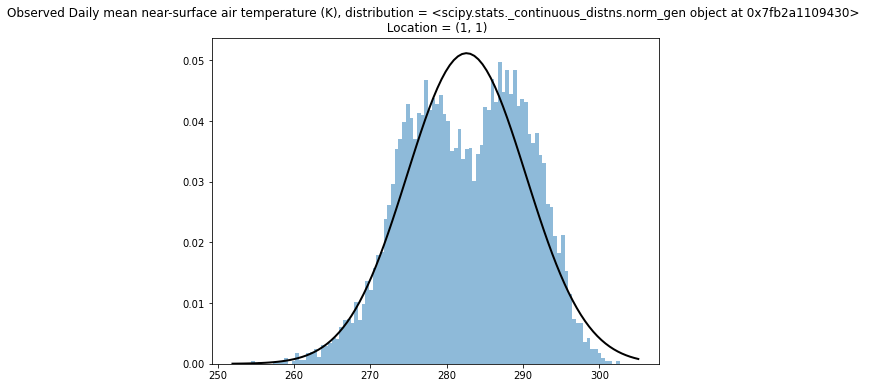

In [13]:
tas_obs_worst_fit = assumptions.plot_worst_fit_aic(variable = 'tas', dataset = tas_obs, 
                                      aic = tas_obs_aic_default, 
                                      data_type = 'Observed', distribution_name = scipy.stats.norm)

Given the plot we see above, and the strong bi-modal distribution of the data, we make the assumption that there is a strong seasonal variation in temperature. This can be further investigated by evaluating the quantile residuals (timeseries, their autocorrelation and a qq-plot of their transformation to normal) - this helps us confirm that there is a strong seasonal effect present that the normal distribution does not capture.

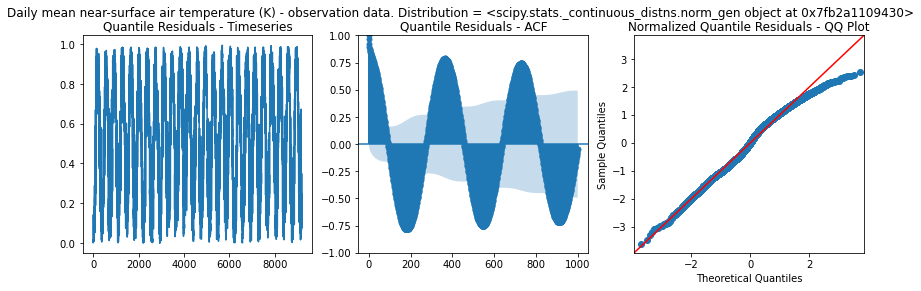

In [14]:
tas_obs_plot_gof = assumptions.plot_quantile_residuals(variable = 'tas', dataset = tas_obs[:,0,0], data_type = 'observation data',
                                                      distribution_name = scipy.stats.norm)

## Initializing and applying the debiasers

**ISIMIP**

In [15]:
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate, verbosity='Error')
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:29<00:00,  7.32s/it]


In [16]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate, verbosity='Error')
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]


In [17]:
tasrange_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasrange_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_validate, **tasrange_dates_validate, verbosity='Error')
tasrange_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_future, **tasrange_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]


In [18]:
tasskew_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasskew_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_validate, **tasskew_dates_validate, verbosity='Error')
tasskew_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_future, **tasskew_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:11<00:00,  2.90s/it]


In [19]:
tasmin_val_debiased_ISIMIP, tasmax_val_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_val_debiased_ISIMIP, tasrange = tasrange_val_debiased_ISIMIP, tasskew = tasskew_val_debiased_ISIMIP)
tasmin_fut_debiased_ISIMIP, tasmax_fut_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_fut_debiased_ISIMIP, tasrange = tasrange_fut_debiased_ISIMIP, tasskew = tasskew_fut_debiased_ISIMIP)

**CDFt**

In [20]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_val_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate, verbosity='Error')
tas_fut_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


In [21]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_val_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate, verbosity='Error')
pr_fut_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  4.01it/s]


**Quantile Delta Mapping**

In [22]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate, verbosity='Error')
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]


In [23]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate, verbosity='Error')
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future, verbosity='Error')

  0%|                                                   | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|███████████████████████████████████████████| 4/4 [00:22<00:00,  5.59s/it]


## Part 2: Evaluation on validation dataset

In [ ]:
tas_metrics = [warm_days, cold_days]
pr_metrics = [dry_days, wet_days, R10mm, R20mm]
tasmin_metrics = [tropical_nights, frost_days]
tasmax_metrics = [summer_days, icing_days]

How to define additional metrics:

In [ ]:
R95p = AccumulativeThresholdMetric(name = '95th percentile \n precipitation', variable = 'pr', 
               threshold_value = [np.quantile(np.ndarray.flatten(pr_obs), 0.95)], threshold_sign = 'higher')

R99p = AccumulativeThresholdMetric(name = '99th percentile \n precipitation', variable = 'pr', 
               threshold_value = [np.quantile(np.ndarray.flatten(pr_obs), 0.99)], threshold_sign = 'higher')

## Part 3: Evaluation of trend preservation

## References